KP

# Recommendation system

Problem statement.

Build a recommender system by using cosine simillarties score.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import cosine, correlation

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
data=pd.read_csv(r"book.csv",encoding='Latin1',index_col=0)
print("Shape:",data.shape)
data.head()

Shape: (10000, 3)


,User.ID,Book.Title,Book.Rating
1,276726,Classical Mythology,5
2,276729,Clara Callan,3
3,276729,Decision in Normandy,6
4,276736,Flu: The Story of the Great Influenza Pandemic...,8
5,276737,The Mummies of Urumchi,6


In [4]:
data = data.rename({'User.ID':'UserId','Book.Title':'Title','Book.Rating':'Rating'}, axis=1)
data

,UserId,Title,Rating
1,276726,Classical Mythology,5
2,276729,Clara Callan,3
3,276729,Decision in Normandy,6
4,276736,Flu: The Story of the Great Influenza Pandemic...,8
5,276737,The Mummies of Urumchi,6
...,...,...,...
9996,162121,American Fried: Adventures of a Happy Eater.,7
9997,162121,Cannibal In Manhattan,9
9998,162121,How to Flirt: A Practical Guide,7
9999,162121,Twilight,8


### EDA and Data Visualization

In [5]:
print('\n Describe:');   print(data.describe())
print('\n Info:');   print(data.info())
print('\n Null values:');   print(data.isnull().sum())
print('\n Duplicated:');   print(data[data.duplicated()])


 Describe:
              UserId       Rating
count   10000.000000  10000.00000
mean    95321.249800      7.56630
std    117645.703609      1.82152
min         8.000000      1.00000
25%      2103.000000      7.00000
50%      3757.000000      8.00000
75%    162052.000000      9.00000
max    278854.000000     10.00000

 Info:
<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 1 to 10000
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   UserId  10000 non-null  int64 
 1   Title   10000 non-null  object
 2   Rating  10000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 312.5+ KB
None

 Null values:
UserId    0
Title     0
Rating    0
dtype: int64

 Duplicated:
      UserId                      Title  Rating
5052    2152  Le nouveau soleil de Teur       7
7440    3757        The Magician's Tale       7


Remove duplicate rows based on all columns

In [6]:
# Remove duplicate rows based on all columns
data = data.drop_duplicates()
print('\n Duplicated:');   print(data[data.duplicated()])


 Duplicated:
Empty DataFrame
Columns: [UserId, Title, Rating]
Index: []


## Variable check

### Find columns with the same values

In [7]:
# Find columns with the same values
columns_with_same_values = data.columns[data.nunique() == 1].tolist()

for column in columns_with_same_values:
    unique_values = data[column].unique()
    print(f"Unique values in the '{column}' column:")
    print(unique_values)
    print()

# excluding columns_with_same_values
data = data.drop(columns=columns_with_same_values)
print("excluded columns_with_same_values, nos:",columns_with_same_values ,",Final shape:", data.shape)

excluded columns_with_same_values, nos: [] ,Final shape: (9998, 3)


In [8]:
# Discrete Variables Count
discrete_feature=[feature for feature in data.columns if len(data[feature].unique())<20 and feature]
print('Discrete Variables Count: {}'.format(len(discrete_feature)))
print(discrete_feature)

# Continuous Feature Count
continuous_feature=[feature for feature in data.columns if data[feature].dtype!='O' and feature not in discrete_feature]
print('\nContinuous Feature Count {}'.format(len(continuous_feature)))
print(continuous_feature)

# Other Features Count
other_feature = [feature for feature in data.columns if feature not in discrete_feature and feature not in continuous_feature]
print('\nOther Features Count: {}'.format(len(other_feature)))
print('Other Features: {}'.format(other_feature))

# Numeric Data
numeric_data = data.select_dtypes(include='number')
print('\nNumeric Data Shape:', numeric_data.shape)
print(numeric_data.columns)

# Categorical Data
categorical_data = data.select_dtypes(include='object')
print('\nCategorical Data Shape:', categorical_data.shape)
print('Categorical Columns:', categorical_data.columns)

Discrete Variables Count: 1
['Rating']

Continuous Feature Count 1
['UserId']

Other Features Count: 1
Other Features: ['Title']

Numeric Data Shape: (9998, 2)
Index(['UserId', 'Rating'], dtype='object')

Categorical Data Shape: (9998, 1)
Categorical Columns: Index(['Title'], dtype='object')


## Rating Visualization 

In [9]:
# Rating Count
rating=pd.DataFrame(data.groupby('Title')['Rating'].mean())
rating['num of rating']=pd.DataFrame(data.groupby('Title')['Rating'].count())
rating

,Rating,num of rating
Title,,
"Jason, Madison &amp",8.0,1
Other Stories;Merril;1985;McClelland &amp,6.0,1
Repairing PC Drives &amp,4.0,1
'48,7.0,1
'O Au No Keia: Voices from Hawai'I's Mahu and Transgender Communities,8.0,1
...,...,...
"\Surely You're Joking, Mr. Feynman!\: Adventures of a Curious Character",8.0,1
"\Well, there's your problem\: Cartoons",9.0,1
iI Paradiso Degli Orchi,7.0,1


### Joint plot

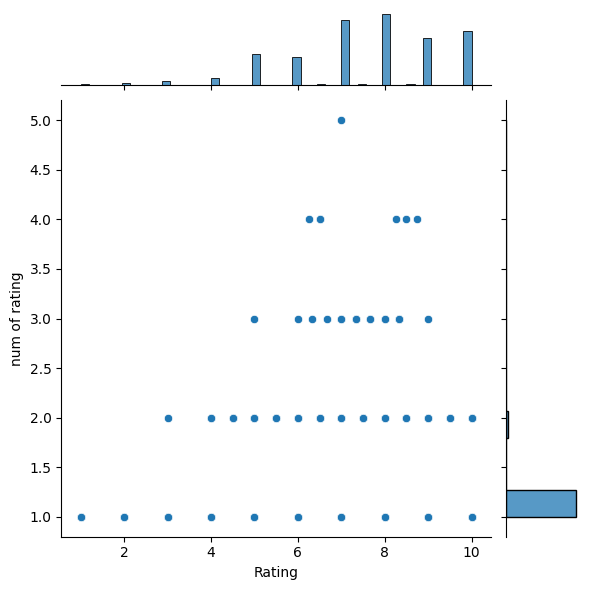

In [10]:
#Joint plot
sns.jointplot(x='Rating',y='num of rating',data=rating)
plt.show()

### distribution plots

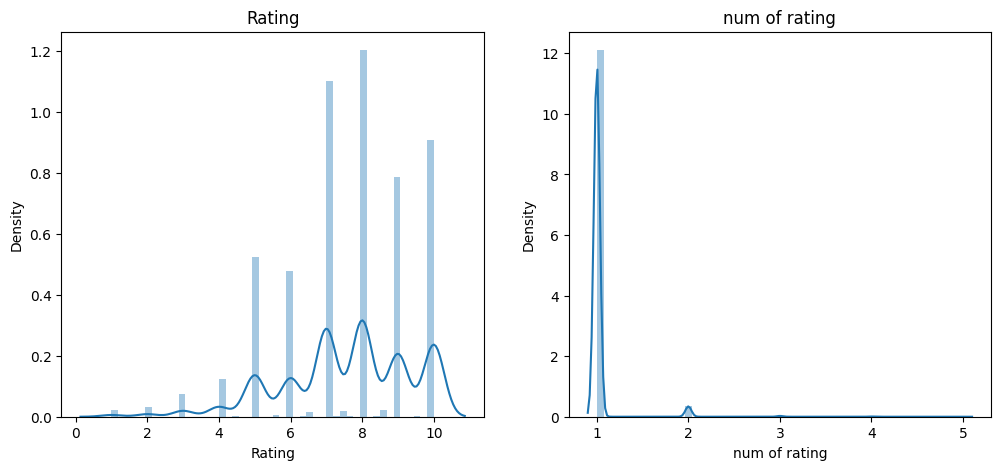

In [11]:
# distribution plots
new_data=rating
subplots_per_row = 2
num_rows = (len(new_data.columns) + subplots_per_row - 1) // subplots_per_row
fig, axes = plt.subplots(num_rows, subplots_per_row, figsize=(12, 5*num_rows))
axes = axes.flatten()

for i, column in enumerate(new_data.columns):
    ax = axes[i]
    sns.distplot(new_data[column], kde=True, ax=ax)
    ax.set_title(column)
    
# Hide any remaining empty subplots
for i in range(len(new_data.columns), num_rows * subplots_per_row):
    fig.delaxes(axes[i])

# plt.tight_layout()
plt.show()

### Histogram & Probability Plot (Q-Q plot)

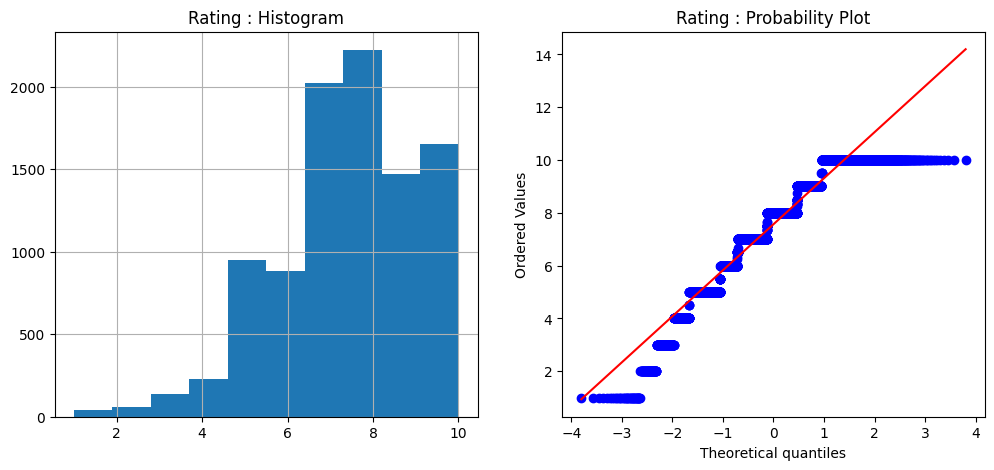

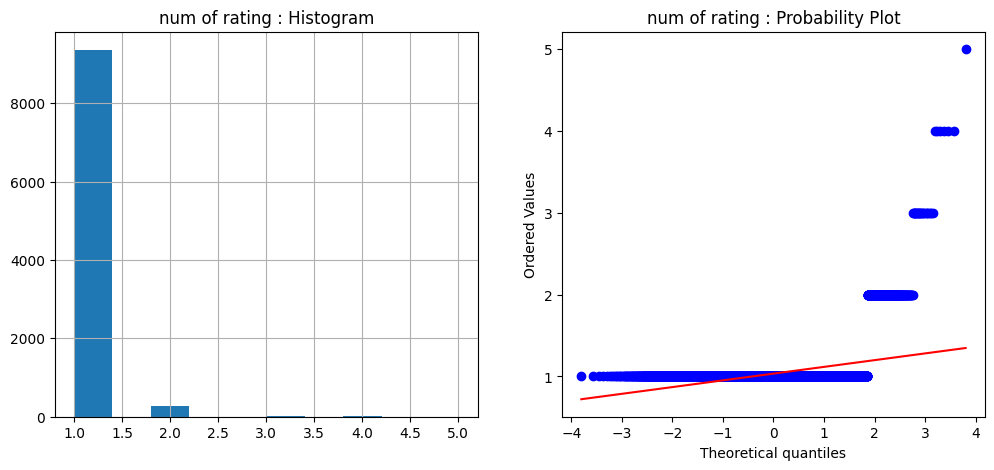

In [12]:
# Histogram & Probability Plot (Q-Q plot)
import pylab
import scipy.stats as stat

def plot_data(df, feature):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    df[feature].hist()
    plt.title(f'{feature} : Histogram')
    plt.subplot(1, 2, 2)
    stat.probplot(df[feature], dist='norm', plot=pylab)
    plt.title(f'{feature} : Probability Plot')

# Iterate through all columns
for column in new_data.columns:
    plot_data(new_data, column)
    plt.show()


## Pivot Table

In [13]:
pivot_table = data.pivot_table(index='UserId', columns='Title', values='Rating')
print("Shape:",pivot_table.shape)
pivot_table

Shape: (2182, 9659)


Title,"Jason, Madison &amp",Other Stories;Merril;1985;McClelland &amp,Repairing PC Drives &amp,'48,'O Au No Keia: Voices from Hawai'I's Mahu and Transgender Communities,...AND THE HORSE HE RODE IN ON : THE PEOPLE V. KENNETH STARR,01-01-00: A Novel of the Millennium,"1,401 More Things That P*Ss Me Off",10 Commandments Of Dating,"100 Great Fantasy Short, Short Stories",...,Zora Hurston and the Chinaberry Tree (Reading Rainbow Book),\Even Monkeys Fall from Trees\ and Other Japanese Proverbs,\I Won't Learn from You\: And Other Thoughts on Creative Maladjustment,"\More More More,\ Said the Baby",\O\ Is for Outlaw,"\Surely You're Joking, Mr. Feynman!\: Adventures of a Curious Character","\Well, there's your problem\: Cartoons",iI Paradiso Degli Orchi,stardust,Ã?Â?bermorgen.
UserId,,,,,,,,,,,,,,,,,,,,,
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
278846,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
278849,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
278851,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.0,NaN,NaN


In [14]:
#Impute those NaNs with 0 values
pivot_table.fillna(0, inplace=True)
pivot_table.head()

Title,"Jason, Madison &amp",Other Stories;Merril;1985;McClelland &amp,Repairing PC Drives &amp,'48,'O Au No Keia: Voices from Hawai'I's Mahu and Transgender Communities,...AND THE HORSE HE RODE IN ON : THE PEOPLE V. KENNETH STARR,01-01-00: A Novel of the Millennium,"1,401 More Things That P*Ss Me Off",10 Commandments Of Dating,"100 Great Fantasy Short, Short Stories",...,Zora Hurston and the Chinaberry Tree (Reading Rainbow Book),\Even Monkeys Fall from Trees\ and Other Japanese Proverbs,\I Won't Learn from You\: And Other Thoughts on Creative Maladjustment,"\More More More,\ Said the Baby",\O\ Is for Outlaw,"\Surely You're Joking, Mr. Feynman!\: Adventures of a Curious Character","\Well, there's your problem\: Cartoons",iI Paradiso Degli Orchi,stardust,Ã?Â?bermorgen.
UserId,,,,,,,,,,,,,,,,,,,,,
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Checking which users are read more books

Encode rating 

In [15]:
def encode_units(x):
    if x<=0:
        return 0
    if x>=1:
        return 1
pivot_table2=pivot_table.applymap(encode_units)
pivot_table2.tail()

Title,"Jason, Madison &amp",Other Stories;Merril;1985;McClelland &amp,Repairing PC Drives &amp,'48,'O Au No Keia: Voices from Hawai'I's Mahu and Transgender Communities,...AND THE HORSE HE RODE IN ON : THE PEOPLE V. KENNETH STARR,01-01-00: A Novel of the Millennium,"1,401 More Things That P*Ss Me Off",10 Commandments Of Dating,"100 Great Fantasy Short, Short Stories",...,Zora Hurston and the Chinaberry Tree (Reading Rainbow Book),\Even Monkeys Fall from Trees\ and Other Japanese Proverbs,\I Won't Learn from You\: And Other Thoughts on Creative Maladjustment,"\More More More,\ Said the Baby",\O\ Is for Outlaw,"\Surely You're Joking, Mr. Feynman!\: Adventures of a Curious Character","\Well, there's your problem\: Cartoons",iI Paradiso Degli Orchi,stardust,Ã?Â?bermorgen.
UserId,,,,,,,,,,,,,,,,,,,,,
278846,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
278849,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
278851,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
278852,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
278854,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


or

In [16]:
pivot_table3 = pivot_table.applymap(lambda x: 1 if x != 0 else 0)
pivot_table3.tail()

Title,"Jason, Madison &amp",Other Stories;Merril;1985;McClelland &amp,Repairing PC Drives &amp,'48,'O Au No Keia: Voices from Hawai'I's Mahu and Transgender Communities,...AND THE HORSE HE RODE IN ON : THE PEOPLE V. KENNETH STARR,01-01-00: A Novel of the Millennium,"1,401 More Things That P*Ss Me Off",10 Commandments Of Dating,"100 Great Fantasy Short, Short Stories",...,Zora Hurston and the Chinaberry Tree (Reading Rainbow Book),\Even Monkeys Fall from Trees\ and Other Japanese Proverbs,\I Won't Learn from You\: And Other Thoughts on Creative Maladjustment,"\More More More,\ Said the Baby",\O\ Is for Outlaw,"\Surely You're Joking, Mr. Feynman!\: Adventures of a Curious Character","\Well, there's your problem\: Cartoons",iI Paradiso Degli Orchi,stardust,Ã?Â?bermorgen.
UserId,,,,,,,,,,,,,,,,,,,,,
278846,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
278849,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
278851,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
278852,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
278854,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [17]:
most_books_users = pivot_table3.sum(axis=1)
print("most_books_users : \n",most_books_users.head(5) )
most_books_users_sorted = most_books_users.sort_values(ascending=False)
print("\nmost_books_users_sorted : \n",most_books_users_sorted.head(5) )
# most_books_user = most_books_users_sorted.idxmax()

print(f"\nThe user who has read the most books is: {most_books_users_sorted.index[0]}, Number of books: {most_books_users_sorted.iloc[0]}")
print(f"\nThe indices of the last user based on the number of books read:: {most_books_users_sorted.index[-1]}, Number of books: {most_books_users_sorted.iloc[-1]}")

most_books_users : 
 UserId
8     7
9     1
10    1
12    1
14    3
dtype: int64

most_books_users_sorted : 
 UserId
3757      522
162052    213
2276      211
4017      156
277427    150
dtype: int64

The user who has read the most books is: 3757, Number of books: 522

The indices of the last user based on the number of books read:: 3934, Number of books: 1


In [18]:
pivot_table3.loc[3757].sum()

522

In [19]:
# extract the books which read by userId  3757
data[(data['UserId']== 3757)]

,UserId,Title,Rating
6999,3757,The Strange Case of Dr. Jekyll and Mr. Hyde an...,7
7000,3757,Almost Vegetarian : A Primer for Cooks Who Are...,8
7001,3757,The Adventures of Buckaroo Banzai : Across the...,6
7002,3757,A General Theory of Love,7
7003,3757,"The Best American Essays, 1989 (Best American ...",7
...,...,...,...
7517,3757,What Happened When: A Chronology of Life and E...,9
7518,3757,Catching Alice,7
7519,3757,Ella Minnow Pea: A Novel in Letters,7
7520,3757,Dave's Way: A New Approach to Old-Fashioned Su...,8


In [20]:
# extract the books which read by userId  3934
data[(data['UserId']== 3934)]

,UserId,Title,Rating
7780,3934,Shark Swimathon (MathStart 3),10


In [21]:
# extract the books which read by userId 276729
data[(data['UserId']==276729)]

,UserId,Title,Rating
2,276729,Clara Callan,3
3,276729,Decision in Normandy,6


In [22]:
# extract the books which read by userId 8
data[(data['UserId']==8)]

,UserId,Title,Rating
2400,8,Ancient Celtic Romances,5
2401,8,The Western way: A practical guide to the West...,5
2402,8,Wings,5
2403,8,Truckers,5
2404,8,Keepers of the Earth Teachers Guide,6
2405,8,The Celts Activity Book,6
2406,8,The Art Of Celtia,7


### Compute Cosine Similarity between Users

In [23]:
# Replacing the index values by unique user Ids
pivot_table4=pivot_table.copy()
# pivot_table4.index = data['UserId'].unique()
# pivot_table4.tail()

cosine_similarity

In [24]:
# Compute Cosine Similarity between Users
from sklearn.metrics.pairwise import cosine_similarity
user_similarity1 = cosine_similarity(pivot_table4, pivot_table4)
user_similarity1

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

or

pairwise_distances

In [25]:
user_similarity=1-pairwise_distances(pivot_table4.values,metric='cosine')
user_similarity

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [26]:
# Nullifying diagonal values
np.fill_diagonal(user_similarity,0)
user_similarity=pd.DataFrame(user_similarity)
user_similarity

,0,1,2,3,4,5,6,7,8,9,...,2172,2173,2174,2175,2176,2177,2178,2179,2180,2181
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2177,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2178,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2179,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2180,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [27]:
#Set the index and column names to user ids 
user_similarity.index = data.UserId.unique()
user_similarity.columns = data.UserId.unique()
user_similarity.tail()

,276726,276729,276736,276737,276744,276745,276747,276748,276751,276754,...,162085,162091,162092,162095,162103,162107,162109,162113,162121,162129
162107,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
162109,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
162113,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
162121,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
162129,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Most Similar Users

In [28]:
# Most Similar Users
similar_user=user_similarity.idxmax(axis=1)
print(similar_user.shape)
similar_user

(2182,)


276726    276726
276729    276726
276736    276726
276737    276726
276744    276726
           ...  
162107    276726
162109    276726
162113    161453
162121    276726
162129    276726
Length: 2182, dtype: int64

In [29]:
# extract the books which userId 276726 & 276729 have watched
data[(data['UserId']==276726) | (data['UserId']==276729)]

,UserId,Title,Rating
1,276726,Classical Mythology,5
2,276729,Clara Callan,3
3,276729,Decision in Normandy,6


In [30]:
# extract the books which userId 276729 & 276726 have watched
data[(data['UserId']==276729) | (data['UserId']==276726)]

,UserId,Title,Rating
1,276726,Classical Mythology,5
2,276729,Clara Callan,3
3,276729,Decision in Normandy,6


In [31]:
# 276726	276729	276736	276737	276744
data[(data['UserId']==276729) | (data['UserId']==276726) | (data['UserId']==276736) | (data['UserId']==276737) | (data['UserId']==276744)]

,UserId,Title,Rating
1,276726,Classical Mythology,5
2,276729,Clara Callan,3
3,276729,Decision in Normandy,6
4,276736,Flu: The Story of the Great Influenza Pandemic...,8
5,276737,The Mummies of Urumchi,6
6,276744,The Kitchen God's Wife,7


# Recommendation Process

In [32]:
custID=276813
simID =user_similarity.loc[custID].idxmax()

data[data['UserId'] == simID]
# data[data['UserId'] == custID]
user_similarity[custID].max()

0.3086974532565159

In [33]:
def recommend(custID, num_recommendations=3):   
    simID = user_similarity.loc[custID].idxmax()
    max_similarity = user_similarity[custID].max()
    if max_similarity == 0:
        print("There is no similarity for custID:",custID)
        return
    else:
        print(custID,":Similar user Id:",simID,"With value:",max_similarity)
        
    simID_books = data[data['UserId'] == simID].Title
    custID_books = data[data['UserId'] == custID].Title
    
    # Calculate recommended books by finding the set difference
    recommended_books = set(simID_books) - set(custID_books)
    
    # Return the specified number of recommendations
    return list(recommended_books)[:num_recommendations]

# Example: Recommend 3 books for customer with ID 276813
recommendations = recommend(276813, num_recommendations=3)
print("Recommended Books:", recommendations)


276813 :Similar user Id: 3546 With value: 0.3086974532565159
Recommended Books: ['Dance the Eagle to Sleep']


In [34]:
# for most watched and least watched
recommend(3757), recommend(3934),recommend(162052)

There is no similarity for custID: 3757
There is no similarity for custID: 3934
There is no similarity for custID: 162052


(None, None, None)

## Advanced Recommendation
where the recommendation is insufficient with single similarity user (less than the specified number)

In [35]:
def recommend_advanced(custID, num_recommendations=3):
    max_similarity = user_similarity[custID].max()
    simID = user_similarity.loc[custID].idxmax()   
    if max_similarity == 0:
        print("There is no similarity")
        return
    else:
        print(custID,":Similar user Id:",simID,"With value:",max_similarity)
    
    simID_books = data[data['UserId'] == simID].Title
    custID_books = data[data['UserId'] == custID].Title
    
    # Calculate recommended books by finding the set difference
    recommended_books = set(simID_books) - set(custID_books)
    
    # If the number of recommendations is insufficient, try the next maximum similarity user
    while len(recommended_books) < num_recommendations:
        user_similarity.loc[custID, simID] = -1  # Set the current similarity to -1 to exclude it
        simID = user_similarity.loc[custID].idxmax()
        max_similarity = user_similarity[custID].max()
        if max_similarity == 0:
            print("There is no similarity")
            return
        else:
            print(custID,":Similar user Id:",simID,"With value:",max_similarity)
        
        simID_books = data[data['UserId'] == simID].Title
        recommended_books.update(set(simID_books) - set(custID_books))
    
    # Return the specified number of recommendations
    return list(recommended_books)[:num_recommendations]

# Example: Recommend 3 books for customer with ID 276813
recommendations = recommend_advanced(276813, num_recommendations=3)
print("Recommended Books:", recommendations)


276813 :Similar user Id: 3546 With value: 0.3086974532565159
276813 :Similar user Id: 276726 With value: 0.3086974532565159
276813 :Similar user Id: 276729 With value: 0.3086974532565159
Recommended Books: ['Dance the Eagle to Sleep', 'Clara Callan', 'Classical Mythology']


In [36]:
recommend_advanced(3546, num_recommendations=2),recommend_advanced(276813, num_recommendations=3),recommend_advanced(276729)

3546 :Similar user Id: 276813 With value: 0.06593356830908481
276813 :Similar user Id: 276729 With value: 0.3086974532565159
276813 :Similar user Id: 276736 With value: 0.3086974532565159
There is no similarity


(['Purity in Death', 'Icebound'],
 ['Clara Callan',
  'Flu: The Story of the Great Influenza Pandemic of 1918 and the Search for the Virus That Caused It',
  'Decision in Normandy'],
 None)